In [87]:
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, GridSearchCV
import random
import time
import numpy as np


In [88]:
tweets = pd.read_csv("data/train_pre_processing_true_false.csv")
x_train, target = tweets.select_dtypes(include=['float64','int64','bool']).iloc[:,:-1],tweets.iloc[:,-1]
#elimina caracteres del nombre del feature que los modelos no pueden manejar
x_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in x_train.columns]


In [89]:
def get_dic_acc():
    results = {}
    results['accuracy'] = []
    results['std'] = []
    results['time'] = []
    results['features'] = []
    results['model'] = []
    
    return results

Se crea una función que elija al azar 100 features del total conseguido (tomando en cuenta que la mayoría son generados por un one hot encoding)

In [90]:
principal_features_list = range(0,42)
secondary_features_list = range(42,len(x_train.columns))

def get_feature_sample():
    principal_features_sample_list = random.sample(principal_features_list, 35)
    secondary_features_sample_list = random.sample(secondary_features_list, 65)
    features_sample_list = []
    features_sample_list.extend(principal_features_sample_list)
    features_sample_list.extend(secondary_features_sample_list)
    features_sample_list.sort()
    
    return features_sample_list

Para entrenar cualquier modelo con CV 

In [91]:
def fit_model_cv(model,train_set,target):
    start = time.time()
    cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=5,random_state=1)
    
    n_scores = cross_val_score(model, train_set, target, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    end = time.time()
    
    return np.mean(n_scores),np.std(n_scores), (end - start)


Modelos a entrenar

In [92]:
def get_models_for_fit():
    xgb_model = xgb.XGBClassifier(random_state=1)
    light_model = LGBMClassifier(random_state = 1)
    rf_model = RandomForestClassifier(random_state=1)

    return [xgb_model,light_model,rf_model]

In [93]:
sample_list = []

results_dict = get_dic_acc()

for x in range(0,500):
    features_sample_list = []
    
    while not features_sample_list in sample_list:
        features_sample_list = get_feature_sample()
        
        if not features_sample_list in sample_list:
            sample_list.append(features_sample_list)

    models = get_models_for_fit()
    train_set = x_train.iloc[:,features_sample_list]
    
    for model in models:
        mean, std, timed = fit_model_cv(model,train_set,target)
        
        results_dict['accuracy'].append(mean)
        results_dict['std'].append(std)
        results_dict['time'].append(timed)
        results_dict['features'].append(features_sample_list)
        results_dict['model'].append(str(model))
    
results_df = pd.DataFrame(results_dict) 

    

In [132]:
results_df

,accuracy,std,time,features,model
0,0.790699,0.013486,92.759706,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...","XGBClassifier(base_score=0.5, booster='gbtree'..."
1,0.788571,0.015089,6.990095,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...","LGBMClassifier(boosting_type='gbdt', class_wei..."
2,0.789938,0.012442,25.098975,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...","RandomForestClassifier(bootstrap=True, ccp_alp..."
3,0.792696,0.012842,69.955751,"[0, 1, 3, 4, 7, 8, 9, 10, 12, 13, 14, 15, 17, ...","XGBClassifier(base_score=0.5, booster='gbtree'..."
4,0.791172,0.013941,6.225833,"[0, 1, 3, 4, 7, 8, 9, 10, 12, 13, 14, 15, 17, ...","LGBMClassifier(boosting_type='gbdt', class_wei..."
...,...,...,...,...,...
1495,0.791224,0.011108,5.547646,"[0, 1, 2, 3, 4, 5, 7, 10, 11, 12, 13, 14, 15, ...","LGBMClassifier(boosting_type='gbdt', class_wei..."
1496,0.791041,0.011719,21.192583,"[0, 1, 2, 3, 4, 5, 7, 10, 11, 12, 13, 14, 15, ...","RandomForestClassifier(bootstrap=True, ccp_alp..."
1497,0.786390,0.013611,63.288443,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15...","XGBClassifier(base_score=0.5, booster='gbtree'..."
1498,0.784839,0.012647,6.059586,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15...","LGBMClassifier(boosting_type='gbdt', class_wei..."


In [147]:
#results_df.to_csv('data/tree_emsamble_default.csv', index=False)

best_features_default = results_df.groupby('model').apply(lambda x: x.nlargest(10,'accuracy')).features.to_frame().reset_index()

best_features_lgbm = []
best_features_xgb = []
best_features_rf = []

for model in best_features_default.iterrows():
    if 'LGBM' in model[1]['model']:
        best_features_lgbm.append(model[1]['features'])
        
    if 'Random' in model[1]['model']:
        best_features_rf.append(model[1]['features']) 
        
    if 'XGB' in model[1]['model']:
        best_features_xgb.append(model[1]['features']) 

# Pruebas buscando mejores hiperparámetros con LigthGBM

In [150]:
def get_grid_lgbm():
    n_estimators = [100,200,300,400,500] 
    learning_rate = [0.05,0.08,0.1]
    subsample = [0.1,0.5,1.0]
    max_depth = [-1,30,20,10]
    min_split_gain = [0.1,0.0,0.5]
    
    return {
               'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'min_split_gain': min_split_gain,
               'subsample': subsample}

In [151]:
grid = get_grid_lgbm()
results_lgbm_df = pd.DataFrame({})

for features in best_features_lgbm:
    
    light_model = LGBMClassifier(random_state = 1)
    cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=5,random_state=1)
    grid_serch_CV = GridSearchCV(estimator = light_model, param_grid = grid, cv = cv, n_jobs = 2, scoring = 'accuracy')
    grid_serch_CV.fit(x_train.iloc[:,features], target)
    results_lgbm_partial_df = pd.DataFrame(grid_serch_CV.cv_results_)
    results_lgbm_partial_df['index_features'] = best_features_lgbm.index(features)
    results_lgbm_df = results_lgbm_df.append(results_lgbm_partial_df,ignore_index=True)
    

In [170]:
#results_lgbm_df.to_csv('data/tree_emsamble_lgbm.csv', index=False)
results_lgbm_df.nlargest(10,'mean_test_score')


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_split_gain,param_n_estimators,param_subsample,params,...,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score,index_features
5010,0.271299,0.034430,0.011451,0.001265,0.05,10,0,100,0.1,"{'learning_rate': 0.05, 'max_depth': 10, 'min_...",...,0.806833,0.801577,0.781866,0.822602,0.783180,0.791064,0.798002,0.012358,1,9
5011,0.274940,0.060042,0.011338,0.001421,0.05,10,0,100,0.5,"{'learning_rate': 0.05, 'max_depth': 10, 'min_...",...,0.806833,0.801577,0.781866,0.822602,0.783180,0.791064,0.798002,0.012358,1,9
5012,0.271106,0.033904,0.011475,0.001801,0.05,10,0,100,1,"{'learning_rate': 0.05, 'max_depth': 10, 'min_...",...,0.806833,0.801577,0.781866,0.822602,0.783180,0.791064,0.798002,0.012358,1,9
5025,0.285479,0.056002,0.011700,0.001088,0.05,10,0.5,100,0.1,"{'learning_rate': 0.05, 'max_depth': 10, 'min_...",...,0.810775,0.804205,0.788436,0.814717,0.781866,0.788436,0.797898,0.011715,4,9
5026,0.340606,0.165106,0.012522,0.001923,0.05,10,0.5,100,0.5,"{'learning_rate': 0.05, 'max_depth': 10, 'min_...",...,0.810775,0.804205,0.788436,0.814717,0.781866,0.788436,0.797898,0.011715,4,9
5027,0.266436,0.025918,0.011375,0.000958,0.05,10,0.5,100,1,"{'learning_rate': 0.05, 'max_depth': 10, 'min_...",...,0.810775,0.804205,0.788436,0.814717,0.781866,0.788436,0.797898,0.011715,4,9
4860,0.267616,0.031216,0.011078,0.001588,0.05,-1,0.1,100,0.1,"{'learning_rate': 0.05, 'max_depth': -1, 'min_...",...,0.805519,0.805519,0.783180,0.816032,0.781866,0.793693,0.797372,0.010918,7,9
4861,0.269755,0.026600,0.010970,0.000885,0.05,-1,0.1,100,0.5,"{'learning_rate': 0.05, 'max_depth': -1, 'min_...",...,0.805519,0.805519,0.783180,0.816032,0.781866,0.793693,0.797372,0.010918,7,9
4862,0.322414,0.090547,0.014055,0.012059,0.05,-1,0.1,100,1,"{'learning_rate': 0.05, 'max_depth': -1, 'min_...",...,0.805519,0.805519,0.783180,0.816032,0.781866,0.793693,0.797372,0.010918,7,9
4905,0.267597,0.027037,0.011381,0.002096,0.05,30,0.1,100,0.1,"{'learning_rate': 0.05, 'max_depth': 30, 'min_...",...,0.805519,0.805519,0.783180,0.816032,0.781866,0.793693,0.797372,0.010918,7,9


# Pruebas buscando mejores hiperparámetros con RF


In [159]:
def get_grid_rf():
    n_estimators = [100,500] 
    max_samples = [0.3,None,0.5]
    max_depth = [None,30,20,10]
    max_features = [5,10,25,'auto']
    
    return {
               'n_estimators': n_estimators,
               'max_samples': max_samples,
               'max_depth': max_depth,
               'max_features': max_features}

In [160]:
grid = get_grid_rf()
results_rf_df = pd.DataFrame({})

for features in best_features_rf:
    
    rf_model = RandomForestClassifier(random_state = 1)
    cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=5,random_state=1)
    grid_serch_CV = GridSearchCV(estimator = rf_model, param_grid = grid, cv = cv, n_jobs = 2, scoring = 'accuracy')
    grid_serch_CV.fit(x_train.iloc[:,features], target)
    results_rf_partial_df = pd.DataFrame(grid_serch_CV.cv_results_)
    results_rf_partial_df['index_features'] = best_features_rf.index(features)
    results_rf_df = results_rf_df.append(results_rf_partial_df,ignore_index=True)

In [172]:
#results_rf_df.to_csv('data/tree_emsamble_rf.csv', index=False)
results_rf_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_max_samples,param_n_estimators,params,split0_test_score,...,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score,index_features
0,0.424381,0.050013,0.024202,0.004164,None,5,0.3,100,"{'max_depth': None, 'max_features': 5, 'max_sa...",0.825459,...,0.812089,0.791064,0.789750,0.808147,0.772668,0.795007,0.792196,0.011822,73,0
1,2.185880,0.250250,0.109952,0.009172,None,5,0.3,500,"{'max_depth': None, 'max_features': 5, 'max_sa...",0.825459,...,0.812089,0.795007,0.783180,0.808147,0.776610,0.795007,0.794612,0.011969,31,0
2,1.129624,0.369087,0.041138,0.015246,None,5,None,100,"{'max_depth': None, 'max_features': 5, 'max_sa...",0.837270,...,0.802891,0.789750,0.796321,0.798949,0.771353,0.789750,0.792275,0.013393,70,0
3,4.105123,0.501397,0.132732,0.011111,None,5,None,500,"{'max_depth': None, 'max_features': 5, 'max_sa...",0.821522,...,0.800263,0.795007,0.785808,0.791064,0.789750,0.795007,0.793747,0.012510,42,0
4,0.647067,0.133647,0.031646,0.007405,None,5,0.5,100,"{'max_depth': None, 'max_features': 5, 'max_sa...",0.830709,...,0.806833,0.795007,0.783180,0.806833,0.785808,0.795007,0.794482,0.010889,32,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,1.873685,0.049448,0.082299,0.007860,10,auto,0.3,500,"{'max_depth': 10, 'max_features': 'auto', 'max...",0.814961,...,0.810775,0.796321,0.788436,0.805519,0.775296,0.785808,0.793667,0.011465,49,9
956,0.686254,0.094265,0.021014,0.003500,10,auto,None,100,"{'max_depth': 10, 'max_features': 'auto', 'max...",0.813648,...,0.812089,0.806833,0.781866,0.806833,0.770039,0.787122,0.793194,0.012842,58,9
957,3.076437,0.075164,0.085026,0.009926,10,auto,None,500,"{'max_depth': 10, 'max_features': 'auto', 'max...",0.816273,...,0.810775,0.800263,0.784494,0.800263,0.773982,0.784494,0.793877,0.011596,38,9
958,0.495062,0.025319,0.019774,0.002275,10,auto,0.5,100,"{'max_depth': 10, 'max_features': 'auto', 'max...",0.818898,...,0.800263,0.800263,0.776610,0.800263,0.772668,0.781866,0.792484,0.011848,66,9


# Pruebas buscando mejores hiperparámetros con XGBOOST


In [164]:
def get_grid_xgb():
    n_estimators = [100,500] 
    learning_rate = [0.01,0.05,0.1]
    max_depth = [3,10]
    subsample = [0.5,1]
    
    return {
               'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample}

In [166]:
grid = get_grid_xgb()
results_xgb_df = pd.DataFrame({})

for features in best_features_xgb:
    
    xgb_model = xgb.XGBClassifier(random_state = 1)
    cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=5,random_state=1)
    grid_serch_CV = GridSearchCV(estimator = xgb_model, param_grid = grid, cv = cv, n_jobs = 2, scoring = 'accuracy')
    grid_serch_CV.fit(x_train.iloc[:,features], target)
    results_xgb_partial_df = pd.DataFrame(grid_serch_CV.cv_results_)
    results_xgb_partial_df['index_features'] = best_features_xgb.index(features)
    results_xgb_df = results_xgb_df.append(results_xgb_partial_df,ignore_index=True)

In [174]:
#results_xgb_df.to_csv('data/tree_emsamble_xgb.csv', index=False)
results_xgb_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,...,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score,index_features
0,3.464470,0.234258,0.010095,0.002440,0.01,3,100,0.5,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.812336,...,0.796321,0.792378,0.756899,0.784494,0.756899,0.783180,0.777799,0.013018,22,0
1,3.573107,0.203524,0.008814,0.001673,0.01,3,100,1,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.803150,...,0.796321,0.793693,0.763469,0.772668,0.746386,0.775296,0.775540,0.013631,24,0
2,15.377340,0.385342,0.017810,0.004059,0.01,3,500,0.5,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.818898,...,0.808147,0.805519,0.783180,0.806833,0.777924,0.793693,0.792091,0.013109,10,0
3,16.809112,0.975605,0.016598,0.003423,0.01,3,500,1,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.820210,...,0.812089,0.809461,0.779238,0.801577,0.775296,0.793693,0.792827,0.012635,7,0
4,7.637499,0.574012,0.014871,0.002335,0.01,10,100,0.5,"{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.820210,...,0.787122,0.809461,0.785808,0.805519,0.771353,0.789750,0.792721,0.012085,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,16.685249,0.401414,0.016578,0.003273,0.1,3,500,1,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.804462,...,0.810775,0.804205,0.776610,0.814717,0.775296,0.777924,0.790935,0.013145,10,9
236,7.739137,0.294032,0.015899,0.002511,0.1,10,100,0.5,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.812336,...,0.775296,0.785808,0.779238,0.798949,0.773982,0.780552,0.783081,0.012727,17,9
237,8.304522,0.406605,0.015547,0.004045,0.1,10,100,1,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.808399,...,0.785808,0.798949,0.784494,0.800263,0.776610,0.785808,0.786444,0.009446,15,9
238,45.951444,4.376380,0.095034,0.066192,0.1,10,500,0.5,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.813648,...,0.775296,0.791064,0.779238,0.783180,0.767411,0.777924,0.775252,0.012174,24,9


# Ensamble usando mayority voting

In [227]:
best_lgbm_models_df =  results_lgbm_df.nlargest(10,'mean_test_score').iloc[:,[4,5,6,7,8,62,63]]
best_lgbm_models_df.columns = ['learning_rate','max_depth','min_split_gain','n_estimators','subsample','rank','features_index']

best_rf_models_df =  results_rf_df.nlargest(10,'mean_test_score').iloc[:,[4,5,6,7,61,62]]
best_rf_models_df.columns = ['max_depth','max_features','max_samples','n_estimators','rank','features_index']


best_xgb_models_df =  results_xgb_df.nlargest(10,'mean_test_score').iloc[:,[4,5,6,7,61,62]]
best_xgb_models_df.columns = ['learning_rate','max_depth','n_estimators','subsample','rank','features_index']



Se reconstruyen los mejores modelos, son entrenados con el total de registros y se crea las prediciones de cada modelo para el set de test 

In [228]:
tweets_test = pd.read_csv("data/test_pre_processing_true_false.csv")
ids = tweets_test.iloc[:,0]
test_set = tweets_test.iloc[:,range(1,len(tweets_test.columns))].select_dtypes(include=['float64','int64','bool'])
test_set.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in x_train.columns]


In [229]:
all_preds = {}

for model in best_lgbm_models_df.iterrows():
    light_model = LGBMClassifier(random_state = 1,learning_rate=model[1]['learning_rate'],max_depth=model[1]['max_depth'],min_split_gain=model[1]['min_split_gain'],n_estimators=model[1]['n_estimators'],subsample=model[1]['subsample'])
    light_model.fit(x_train.iloc[:,best_features_lgbm[model[1]['features_index']]], target)
    preds = light_model.predict(test_set.iloc[:,best_features_lgbm[model[1]['features_index']]])
    preds = np.where(preds==0, -1, preds) / model[1]['rank']
    all_preds[str(model)] = preds

    

In [230]:
for model in best_rf_models_df.iterrows():
    rf_model = RandomForestClassifier(random_state = 1,max_depth=model[1]['max_depth'],max_features=model[1]['max_features'],n_estimators=model[1]['n_estimators'],max_samples=model[1]['max_samples'])
    rf_model.fit(x_train.iloc[:,best_features_rf[model[1]['features_index']]], target)
    preds = rf_model.predict(test_set.iloc[:,best_features_rf[model[1]['features_index']]])
    preds = np.where(preds==0, -1, preds) / model[1]['rank']
    all_preds[str(model)] = preds
    
    

In [231]:
for model in best_xgb_models_df.iterrows():
    xgb_model = xgb.XGBClassifier(random_state = 1,learning_rate=model[1]['learning_rate'],max_depth=model[1]['max_depth'],n_estimators=model[1]['n_estimators'],subsample=model[1]['subsample'])
    xgb_model.fit(x_train.iloc[:,best_features_xgb[model[1]['features_index']]], target)
    preds = xgb_model.predict(test_set.iloc[:,best_features_xgb[model[1]['features_index']]])
    preds = np.where(preds==0, -1, preds) / model[1]['rank']
    all_preds[str(model)] = preds
    

Finalmente se construye el df a submitear

In [232]:
len(all_preds)

30

all_preds_df = pd.DataFrame(all_preds,index=ids)
submit =  all_preds_df.sum(axis=1).transform(lambda x: 1 if x >= 0 else 0).reset_index()
submit.columns = ['id','target']
submit

In [234]:
submit.to_csv('data/submit_kaggle_ensamble_tree_10', index=False)

# Un poco de comparaciones

In [257]:
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt



In [239]:
def get_model(x):
    if 'XGB' in x:
        return 'XGBoost'
    if 'LGBM' in x:
        return 'LigthGBM'
    if 'RandomForest' in x:
        return 'RamdonForest'

In [263]:
models_default = results_df.copy()
models_default['model'] = models_default.model.transform(lambda x: get_model(x))
models_default['features'] = models_default.features.transform(lambda x: str(x))
models_default

,accuracy,std,time,features,model
0,0.790699,0.013486,92.759706,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...",XGBoost
1,0.788571,0.015089,6.990095,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...",LigthGBM
2,0.789938,0.012442,25.098975,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...",RamdonForest
3,0.792696,0.012842,69.955751,"[0, 1, 3, 4, 7, 8, 9, 10, 12, 13, 14, 15, 17, ...",XGBoost
4,0.791172,0.013941,6.225833,"[0, 1, 3, 4, 7, 8, 9, 10, 12, 13, 14, 15, 17, ...",LigthGBM
...,...,...,...,...,...
1495,0.791224,0.011108,5.547646,"[0, 1, 2, 3, 4, 5, 7, 10, 11, 12, 13, 14, 15, ...",LigthGBM
1496,0.791041,0.011719,21.192583,"[0, 1, 2, 3, 4, 5, 7, 10, 11, 12, 13, 14, 15, ...",RamdonForest
1497,0.786390,0.013611,63.288443,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15...",XGBoost
1498,0.784839,0.012647,6.059586,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15...",LigthGBM


In [277]:
models_default.nlargest(1,'accuracy')

,accuracy,std,time,features,model
981,0.794797,0.012351,63.834126,"[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 1...",XGBoost


In [279]:
models_default.nsmallest(1,'accuracy')

,accuracy,std,time,features,model
289,0.777169,0.012949,5.860996,"[0, 1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 1...",LigthGBM


In [281]:
models_default.accuracy.mean()

0.7890877892168869

In [352]:
models_default.groupby('model').agg({'accuracy':['mean','max','min'],'std':['mean','max','min'],'features':'count'})

accuracy                           std                      \
                  mean       max       min      mean       max       min   
model                                                                      
LigthGBM      0.789136  0.794220  0.777169  0.012287  0.015089  0.009304   
RamdonForest  0.788100  0.793484  0.778825  0.011376  0.013810  0.009330   
XGBoost       0.790028  0.794797  0.779586  0.013218  0.015688  0.011129   

             features  
                count  
model                  
LigthGBM          500  
RamdonForest      500  
XGBoost           500

In [284]:
models_default.nlargest(1,'std')

,accuracy,std,time,features,model
1311,0.789542,0.015688,63.341479,"[1, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",XGBoost


In [285]:
models_default.nsmallest(1,'std')

,accuracy,std,time,features,model
298,0.790883,0.009304,5.531424,"[0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 1...",LigthGBM


In [288]:
models_default.groupby('model')['std'].mean().to_frame()

,std
model,
LigthGBM,0.012287
RamdonForest,0.011376
XGBoost,0.013218


In [294]:
models_default.nlargest(1,'time')

,accuracy,std,time,features,model
0,0.790699,0.013486,92.759706,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...",XGBoost


In [295]:
models_default.nsmallest(1,'time')

,accuracy,std,time,features,model
1489,0.787284,0.01061,5.218858,"[1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 1...",LigthGBM


In [297]:
models_default.groupby('model')['time'].mean().to_frame()

,time
model,
LigthGBM,5.859576
RamdonForest,21.221289
XGBoost,64.582226


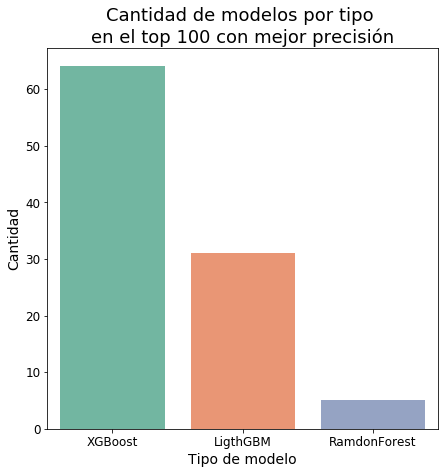

In [289]:
sns.set_palette("Set2")
rcParams['figure.figsize'] = 7,7
ax = sns.barplot(data = models_default.nlargest(100,'accuracy').model.value_counts().to_frame().reset_index()  ,x='index',y='model')
ax.set_title("Cantidad de modelos por tipo \nen el top 100 con mejor precisión",fontsize= 18)
ax.set_ylabel("Cantidad",fontsize= 14)
ax.set_xlabel("Tipo de modelo",fontsize= 14)
plt.tick_params(axis="y", labelsize=12)
plt.tick_params(axis="x", labelsize=12)

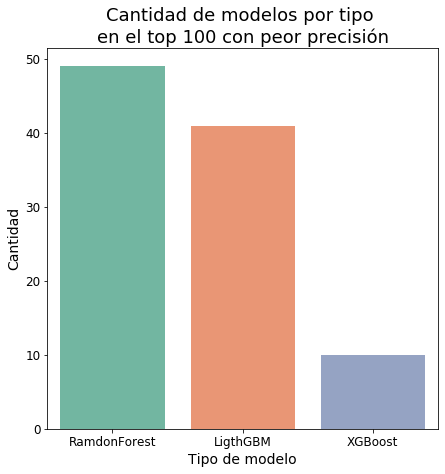

In [290]:
rcParams['figure.figsize'] = 7,7
ax = sns.barplot(data = models_default.nsmallest(100,'accuracy').model.value_counts().to_frame().reset_index()  ,x='index',y='model')
ax.set_title("Cantidad de modelos por tipo \nen el top 100 con peor precisión",fontsize= 18)
ax.set_ylabel("Cantidad",fontsize= 14)
ax.set_xlabel("Tipo de modelo",fontsize= 14)
plt.tick_params(axis="y", labelsize=12)
plt.tick_params(axis="x", labelsize=12)

In [291]:
models_default.groupby('features').apply(lambda x: x.nlargest(1,'accuracy')).model.value_counts().to_frame().reset_index()


,index,model
0,XGBoost,330
1,LigthGBM,124
2,RamdonForest,46


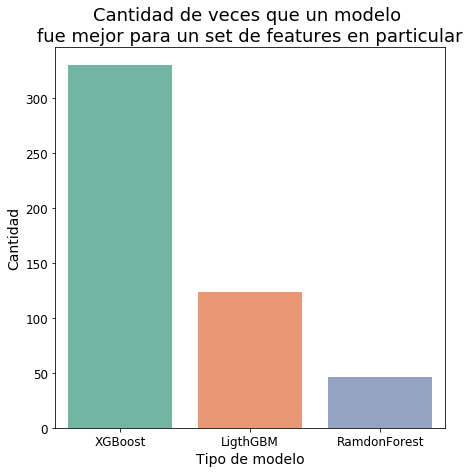

In [292]:
rcParams['figure.figsize'] = 7,7
ax = sns.barplot(data = models_default.groupby('features').apply(lambda x: x.nlargest(1,'accuracy')).model.value_counts().to_frame().reset_index(),x='index',y='model')
ax.set_title("Cantidad de veces que un modelo \nfue mejor para un set de features en particular",fontsize= 18)
ax.set_ylabel("Cantidad",fontsize= 14)
ax.set_xlabel("Tipo de modelo",fontsize= 14)
plt.tick_params(axis="y", labelsize=12)
plt.tick_params(axis="x", labelsize=12)

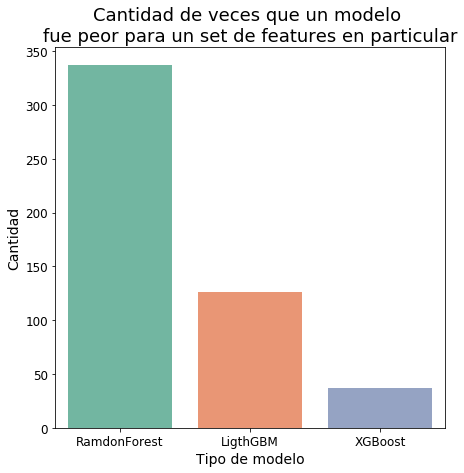

In [293]:
ax = sns.barplot(data = models_default.groupby('features').apply(lambda x: x.nsmallest(1,'accuracy')).model.value_counts().to_frame().reset_index(),x='index',y='model')
ax.set_title("Cantidad de veces que un modelo \nfue peor para un set de features en particular",fontsize= 18)
ax.set_ylabel("Cantidad",fontsize= 14)
ax.set_xlabel("Tipo de modelo",fontsize= 14)
plt.tick_params(axis="y", labelsize=12)
plt.tick_params(axis="x", labelsize=12)

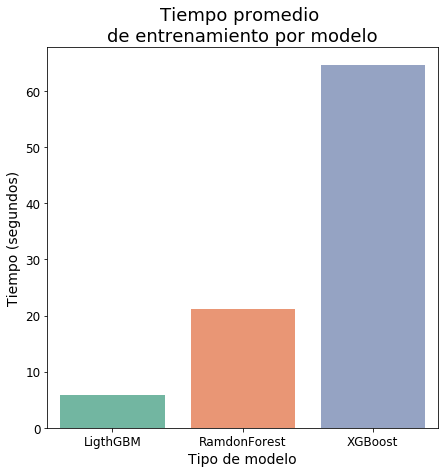

In [301]:
ax = sns.barplot(data = models_default.groupby('model')['time'].mean().to_frame().reset_index(),x='model',y='time')
ax.set_title("Tiempo promedio \nde entrenamiento por modelo",fontsize= 18)
ax.set_ylabel("Tiempo (segundos)",fontsize= 14)
ax.set_xlabel("Tipo de modelo",fontsize= 14)
plt.tick_params(axis="y", labelsize=12)
plt.tick_params(axis="x", labelsize=12)

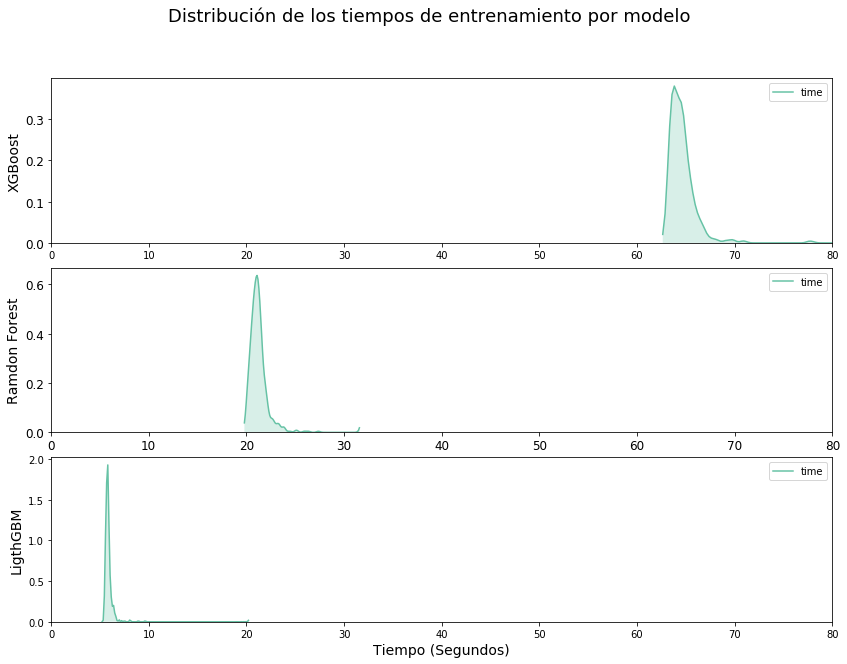

In [346]:
f, ax = plt.subplots(3, 1, figsize=(14,10),gridspec_kw={'hspace': 0.15})
sns.kdeplot(models_default.loc[models_default.model=='XGBoost'].time,shade=True,ax=ax[0],cut=0)
sns.kdeplot(models_default.loc[models_default.model=='RamdonForest'].time,shade=True,ax=ax[1],cut=0)
sns.kdeplot(models_default.loc[models_default.model=='LigthGBM'].time,shade=True, ax=ax[2],cut=0)
f.suptitle('Distribución de los tiempos de entrenamiento por modelo', fontsize=18)
ax[0].set_xlim([0, 80])
ax[1].set_xlim([0, 80])
ax[2].set_xlim([0, 80])
ax[0].set_ylabel("XGBoost",fontsize=14)
ax[1].set_ylabel("Ramdon Forest",fontsize=14)
ax[2].set_ylabel("LigthGBM",fontsize=14)
ax[2].set_xlabel("Tiempo (Segundos)",fontsize=14)
ax[0].tick_params(axis="y", labelsize=12)
ax[1].tick_params(axis="x", labelsize=12)
ax[1].tick_params(axis="y", labelsize=12)
